In [1]:
import json
import pandas as pd
import numpy as np
import re

In [2]:
file_dir = '../Movies-ETL'

In [3]:
f'{file_dir}'

'../Movies-ETL'

In [4]:
movies_metadata = pd.read_csv('../Movies-ETL/Data/movies_metadata.csv', low_memory=False)
rating = pd.read_csv('../Movies-ETL/Data/ratings.csv')

In [5]:
kaggle_metadata = pd.read_csv(f'{file_dir}/Data/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{file_dir}/Data/ratings.csv')

In [6]:
#rating.head()
#kaggle_metadata.sample(n=5)

In [7]:
with open(f'{file_dir}/wikipedia-movies.json', mode='r') as file:
    wiki_movies_raw = json.load(file)

In [8]:
len(wiki_movies_raw)

7311

In [9]:
# First 5 records
#wiki_movies_raw[:5]

# Last 5 records
#wiki_movies_raw[-5:]

# Some records in the middle
#wiki_movies_raw[3600:3605]

In [10]:
wiki_movies_df = pd.DataFrame(wiki_movies_raw)
#wiki_movies_df.head(10)
#wiki_movies_df.columns.to_list()

In [11]:
wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie
                   and 'No. of episodes' not in movie]
len(wiki_movies)

7076

In [12]:
wiki_df = pd.DataFrame(wiki_movies)
#wiki_df.head()

In [13]:
wiki_movies_clean_df = pd.DataFrame(wiki_movies)
#wiki_movies_clean_df.columns.to_list()

In [14]:
#wiki_movies_df[wiki_movies_df['Arabic'].notnull()]['url']
#sorted(wiki_movies_df.columns.tolist())
#wiki_movies_df.head()

In [15]:
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
     # combine alternate titles into one list
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles
        
     # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')
            
    return movie

In [16]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]
wiki_movies_df = pd.DataFrame(clean_movies)
#sorted(wiki_movies_df.columns.tolist())

In [17]:
clean_movies_df = pd.DataFrame(clean_movies)

In [18]:
#clean_movies_df.columns.to_list()

In [19]:
wiki_movies_df = pd.DataFrame(clean_movies)
#sorted(wiki_movies_df.columns.tolist())

In [20]:
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))
#wiki_movies_df.head()

7076
7033


In [21]:
#[[column,wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]
#[column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]

In [22]:
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [23]:
#wiki_movies_df.dtypes

In [24]:
box_office = wiki_movies_df['Box office'].dropna()
#box_office

In [25]:
def is_not_a_string(x):
    return type(x) != str
#box_office[box_office.map(is_not_a_string)]
box_office[box_office.map(lambda x: type(x) != str)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
74                    [$6,488,144, (US), [1]]
126                [US$1,531,489, (domestic)]
130                          [US$, 4,803,039]
                        ...                  
6980               [$99.6, million, [4], [5]]
6994                   [$365.6, million, [1]]
6995                         [$53.8, million]
7015                     [$435, million, [7]]
7048                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [26]:
#some_list = ['One','Two','Three','']
#'Mississippi'.join(some_list)

In [27]:
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)
box_office

0          $21.4 million
1           $2.7 million
2            $57,718,089
3             $7,331,647
4       $6,939,946 (USA)
              ...       
7070       $19.4 million
7071       $41.9 million
7072       $76.1 million
7073       $38.4 million
7074        $5.5 million
Name: Box office, Length: 5485, dtype: object

In [28]:
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

In [29]:
box_office.str.contains(form_one, flags=re.IGNORECASE, na=False).sum()

3903

In [30]:
box_office.str.contains(form_two, flags=re.IGNORECASE, na=False).sum()

1559

In [31]:
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE, na=False)

In [32]:
# this will throw an error!
#box_office[(not matches_form_one) and (not matches_form_two)]
#code we want to use
box_office[~matches_form_one & ~matches_form_two]

110              $4.35-4.37 million
600                      $5000 (US)
1070                     35,254,617
1480                     £3 million
1865                   ¥1.1 billion
2032                            N/A
2091                           $309
2665    926,423 admissions (France)
3088      $32 [2] –33.1 million [1]
3631                            TBA
3859             $38.9–40.3 million
3879       CN¥3.650 million (China)
4116                     £7,385,434
4261             $20.7–23.9 million
4306                         $20-30
4561        $45.2k (only in Turkey)
5447                          £2.56
5784                       413 733$
6013                        Unknown
6145             $17.5–18.4 million
6234             $41.8–41.9 million
6369                          $111k
6370                           $588
6593                 less than $372
6843                        8 crore
Name: Box office, dtype: object

In [33]:
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
#box_office

In [34]:
box_office.str.extract(f'({form_one}|{form_two})')

,0
0,$21.4 million
1,$2.7 million
2,"$57,718,089"
3,"$7,331,647"
4,"$6,939,946"
...,...
7070,$19.4 million
7071,$41.9 million
7072,$76.1 million
7073,$38.4 million


In [35]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [36]:
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [37]:
wiki_movies_df['box_office']

0       21400000.0
1        2700000.0
2       57718089.0
3        7331647.0
4        6939946.0
           ...    
7071    41900000.0
7072    76100000.0
7073    38400000.0
7074     5500000.0
7075           NaN
Name: box_office, Length: 7033, dtype: float64

In [38]:
wiki_movies_df.drop('box_office', axis=1, inplace=True)

In [39]:
budget = wiki_movies_df['Budget'].dropna()

In [40]:
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

In [41]:
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [42]:
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)
budget[~matches_form_one & ~matches_form_two]

136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973             $34 [3] [4] million
1126               $120 [4] million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360               $150 [6] million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034              $$200 [4] million
5055           $155 [2] [3] million
5419                $40 [4] 

In [43]:
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973                     $34 million
1126                   $120 million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360                   $150 million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034                  $$200 million
5055                   $155 million
5419                    $40 

In [44]:
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [47]:
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [48]:
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [50]:
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[0123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [51]:
release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

,0
0,"July 11, 1990"
1,"May 17, 1990"
2,"August 10, 1990"
3,"December 25, 1990"
4,"December 19, 1990"
...,...
7071,"December 25, 2018"
7072,"December 11, 2018"
7073,"November 8, 2018"
7074,"August 31, 2018"


In [52]:
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

In [54]:
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
#running_time

0                                 102 minutes
1                                 114 minutes
2                                 113 minutes
3                                 106 minutes
4                                  95 minutes
                        ...                  
7071                               90 minutes
7072                              132 minutes
7073                              120 minutes
7074                              123 minutes
7075    Variable; 90 minutes for default path
Name: Running time, Length: 6894, dtype: object

In [56]:
running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE, na=False).sum()

6528

In [61]:
running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE, na=False) != True]

9                                                 102 min
26                                                 93 min
28                                                32 min.
34                                                101 min
35                                                 97 min
                              ...                        
6500       114 minutes [1] 120 minutes (extended edition)
6643                                             104 mins
6709    90 minutes (theatrical) [1] 91 minutes (unrate...
7057    108 minutes (Original cut) 98 minutes (UK cut)...
7075                Variable; 90 minutes for default path
Name: Running time, Length: 366, dtype: object

In [58]:
running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False).sum()

6877

In [60]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')

In [62]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')

In [63]:
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

In [64]:
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

In [65]:
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [66]:
kaggle_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [67]:
kaggle_metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [68]:
kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

In [70]:
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [71]:
kaggle_metadata['video'] == 'True'

0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464    False
45465    False
Name: video, Length: 45454, dtype: bool

In [72]:
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [73]:
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [74]:
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

In [75]:
ratings.info(null_counts=True)

/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [76]:
pd.to_datetime(ratings['timestamp'], unit='s')

0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

In [79]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
#ratings

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

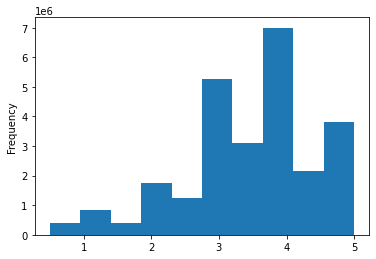

In [80]:
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()